# RL coursework, part III (25 pts total)
---

**SN:** 15056601

---

**Due date:** *22nd March, 2022,*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part3.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

# The Assignment

### Objectives

You will be guided through the implementation of a full deep reinforcement learning agent.

## Setup

Run all the cells in this section, but do not modify them.

## Imports

In [20]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

## Helpers

# A) Actor-critics

You are going to implement an Actor-critic agent that updates a policy parametrised as a deep neural network.

The agent learns online from a single stream of experience, updating the parametes of its policy after each transition in the environment.

### Install packages

In [21]:
!pip install --upgrade jaxlib==0.1.74
!git clone https://github.com/deepmind/bsuite.git
!pip install bsuite/
!pip install dm-haiku==0.0.6

fatal: destination path 'bsuite' already exists and is not an empty directory.
Processing ./bsuite
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for bsuite: filename=bsuite-0.3.5-py3-none-any.whl size=250321 sha256=d730a86978247f04e76bc2b7d1bf1a43235577aaaf2301e1a9bdff2f91326cc6
  Stored in directory: /tmp/pip-ephem-wheel-cache-6pxtevsd/wheels/9b/17/99/f06e5281ca86b7afe85c0515439b017781ea1dbec73e020501
Successfully built bsuite
  Attempting uninstall: bsuite
    Found existing installation: bsuite 0.3.5
    Uninstalling bsuite-0.3.5:
      Successfully uninstalled bsuite-0.3.5


In [22]:
# solution
!pip install optax
!pip install rlax

### Imports

In [23]:
from bsuite.environments import catch

import jax
import jax.numpy as jnp
import haiku as hk

In [24]:
# solution
import optax
import rlax

### Plotting

In [25]:
def plot_learning_curve(list_of_episode_returns):
  """Plot the learning curve."""
  plt.figure(figsize=(7, 5))

  def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

  smoothed_returns = moving_average(list_of_episode_returns, 30)
  plt.plot(smoothed_returns)

  plt.xlabel('Average episode returns')
  plt.xlabel('Number of episodes')

  ax = plt.gca()
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(True)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')

### Neural networks

You will use JAX to define a network parametrising:

* The values of each state $v(s)$.
* The action preferences in each state $\{p_i(s)\}_{i\in\{1, ..., |A|\}}$ (you can think of and implement the preferences $\mathbf{p}(s)$ as a vector output with $|A|$ elements).

You will use `Haiku` (https://github.com/deepmind/dm-haiku) to define the network. You will need to:
* define the forward pass of the network as some function `fn`
* Use `hk.transform(fn)` to convert this in a pair of functions `init_net` and `apply_net`):


        init_net, apply_net = hk.transform(fn)

The `init` function has signature `parameters = init_net(key, obs)`, where
  * `key` is a Jax random-number-generator key that we will generate with `jax.random.PRNGKey`,
  * `observation` is the observation of the agent, which will be flattened into a vector by the network, as described below.

The `init_net` returns randomly sampled weights for the neural network:

        parameters = init_net(jax.random.PRNGKey(1234), observation)

The `apply_net` will have signature `v, p = apply_net(parameters, current_key, obs)` 
  * `parameters`: the (current) parameters of the ageent,
  * `key`: a Jax random keym, e.g., generated with `current_key, key = jax.random.split(key)` (we then keep `key`, which is also a new key, around to split again the next time we need a random key),
  * `observation`: the observation of the agent.

The `apply_net` function then returns a **scalar** value `v` and a **vector** of preferences `p`, which will define the policy of the agent.

A lot of the boilerplate code has been written for you.  You just have to implement some functions as indicated in the questions below.

### Q1 [2 marks]

Define the forward pass of the neural network. The network must:

* take an `observation` as input
* reshape the observation into a flat vector `flat_obs`
* compute a hidden representation `h = relu(W.dot(flat_obs) + b)`, where `relu(x)` is a 'rectifier linear unit', which computes $\max(x, 0)$ elementwise (you can just use `jax.nn.relu(x)` to implement this),
* compute a vector of action preferences as a linear function of `h`
* compute a scalar state value as a linear function of `h`
* return the scalar value and vector preferences.

Note:
* The hidden representation should be a vector of 50 elements.
* The action preferences should be a vector of 3 elements (one per each available action).
* The value should be a scalar (not a vector with one element).


In [26]:
def forward_pass(observation):
    # Define network with 1 layer of 50 nodes with ReLU and 3 outputs nodes
    network = hk.Sequential([
                        lambda flat_obs: jnp.reshape(flat_obs, (-1, )),
                        hk.Linear(50), 
                        jax.nn.relu])
    # Compute a hidden rep 
    h = network(observation)
    # Compute vector pref as a linear function of h
    p =  hk.Linear(3)(h)
    # Compute the state
    s =  hk.Linear(1)(h)
    # Compute the value
    v = jnp.squeeze(s, axis=-1)
    return v, p
# Our forward pass will be deterministic, so we apply `hk.without_apply_rng`.
init_net, apply_net = hk.without_apply_rng(hk.transform(forward_pass))

### Choosing actions

A critical component of an actor-critic agent is a (stochastic) policy, mapping `observations` to `actions`. 

In deep RL, this mapping is conventionally parametrised by a deep neural network.

### Q2 [2 marks]

Implement a softmax policy parametrised by the neural network above (i.e., using the `apply_net` function).

The function has signature `action = softmax_policy(parameters, key, obs)`, taking the current network parameters `parameters`, a JAX random `key` and the current `observation`. It should return an `action` sampled from a softmax distribution, so that the probability of selecting action $a$ with preference $p(s, a)$ is proportional to $\exp(p(s, a))$.

Functions to perform random sampling in JAX (e.g. those in `jax.random`) take a random key as input, and they are deterministic function of such a key. In general, in a JAX program you need to use the `jax.random.split` function to generate new random keys before every new sampling. The run loop that runs the experiment later on splits the key between consecutive calls to the `policy`. Thus you can assume that a new random `key` is provided to you on each call to the `policy`. If, however, you find that you need a random key in multiple places within the `policy`, do remember to split the key before each use, using `key1, key2 = jax.random.split(key)`.

Note that we 'jit' the function.  This means the function will be compiled, which will make it run faster. This does also suppress print statements, so if you are debugging and want to print please comment out the `@jax.jit` line, but don't forget to put it back before running the experiment below, and especially before submitting your assignment.

In [27]:
@jax.jit
def softmax_policy(parameters, key, obs):
    """Sample action from a softmax policy."""
    # Get the state and action prefs
    v, p = apply_net(parameters, obs)
    # Convert to softmax 
    sm = jax.nn.softmax(p)
    # Generate an action using the softmax
    action = jax.random.choice(key,jnp.arange(0,3), p=sm)
    # Return action
    return action

### Learning values and policies

An actor-critic agent requires to update the parameters of the network so as to simultaneously improve the value predictions and the policy.

In the next section you will define the gradient updates for each of these two components.

### Q3 [4 marks]

Implement a function to compute a stochastic estimate of the policy gradient from a 1 step transition in the environment.

* You will use $R_{t+1} + \gamma v(S_{t+1})$ as an estimate of $q_{\pi}(S_t, A_t)$
* You will use $v(S_{t})$ as a baseline to reduce the variance of the updates.

In the code we actually use names `obs_tm1`, `a_tm1` (where `tm1` stands for '$t$ minus one') for the observation and action at time $t-1$, and `r_t`, `discount_t`, `obs_t` for the reward, discount, and observation at time $t$. So the code is offset a single time step in terms of naming as compared to the typical mathematical formulations.  This is just a naming convention, and should not impact the algorithm.

The function below must therefore have signature `grads = policy_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)`.
* Where the inputs are:
  * `parameters`: the parameters of the network,
  * an observation `obs_tm1`
  * the action `a_tm1` selected after observing `obs_tm1`,
  * the resulting reward `r_t` and discount `discount_t` and observation `obs_t`, as obsesrved after taking action `a_tm1`.

This function should return a stochastic estimate of the policy gradient, where `grads` has the same structure as `parameters` and contains an estimate of the gradient of the expected episodic return wrt to each parameter.

The policy-gradient estimate should use bootstrapping, using the value estimates that can be gotten using the saame `parameters` as used for the policy.  So the output of this function can be used in a one-step actor-critic update.


### Jax hint:
Note that you can use `jax.grad(f)` to get the gradient of any (pure) jax function with a scalar output.  For instance, consider:

        def f(w, x, y):
          # w, x, and y are all vectors
          return jnp.sum(w*x + y)

        df = jax.grad(f)
    
then calling `df(w, x, y)` will give the gradient of the output of `f(w, x, y)` with respect to the first input argument --- here called `w`. You can use this new function `df` as just a normal function. For instance, it can be called from other functions, as usual.

Run the cell below to see a concrete example in action.  Note that `df(w, x, y)` in the example below evaluates to the same values as `x`.  This is correct, because the gradient of `f` with respect to `w` is indeed `x`.

In [28]:
def f(w, x, y):
  return jnp.sum(w*x + y)

df = jax.grad(f)

w = jnp.array([1., 2.])
x = jnp.array([3., 5.])
y = jnp.array([7., 11.])

print(f'f(w, x, y):  {f(w, x, y)}')
print(f'df(w, x, y): {df(w, x, y)}')

f(w, x, y):  31.0
df(w, x, y): [3. 5.]


### Jax hint:
if you have a Haiku network with parameters `w`, then these parameters will typically be a structured dictionary containing the actual weight vectors and matrices that make up the network's parameters.  Suppose you have a function that computes the output of a network, and then uses this to do some stuff, and you want the gradient of that function:

        # Define network
        def some_haiku_net(...):
          ...

        # Transform to get init and apply
        init, apply = hk.without_apply_rng(hk.transform(some_haiku_net))

        # Define a new function
        def some_function(w, x, y):
           ...some stuff...
           # compute output of the network:
           output = apply(w, x)
           ...some more stuff that uses output...
           return ...some_scalar...
        
        grad_function = jax.grad(some_function)

As before, `grads = grad_function(w, x, y)` should now give the gradients of `some_function` with respect to the first input argument, `w`.  These gradients `grads` will have exactly the same shape as the input argment `w`.  But we cannot do things like `w + grads`, because `w` and `grads` are both dictionaries, not just `jnp.array`s.  Instead, we can use Jax' inbuilt tree utils.  For instance, to add the gradients to the weights, we can use:
`new_weights = jax.tree_map(lambda w_i, g_i: w_i + 0.1 * g_i, w, grads)`


In [29]:
def policy_loss(parameters, obs_tm, a_tm):
  # Get the state value and next action
  v_next, next_act = apply_net(parameters, obs_tm)
 
  # Compute the log probability of the policy
  prob_log = jax.nn.log_softmax(next_act)[a_tm]
  return prob_log
 
def policy_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    # Get the baseline and current action
    v_baseline, curr_act = apply_net(parameters, obs_tm1)
    
    # Get the state value and next action
    v_next, next_act = apply_net(parameters, obs_t)
    
    # Compute the loss
    loss = r_t + discount_t * v_next - v_baseline
    loss = loss.squeeze()
 
    # Return the gradient of the policy loss with respect to the first input
    grads = jax.grad(policy_loss)(parameters,obs_tm1,a_tm1)
    grads = jax.tree_multimap(lambda g_i: g_i*loss, grads)
    return grads

### Q4 [4 marks]

Implement a function to compute a TD(0) update for the parameters of the value function.

It must have signature `td_update = value_update(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)`.
* Where the inputs are:
  * the current parameters `parameters` of the network,
  * an observation `obs_tm1`
  * the action `a_tm1` selected after observing `obs_tm1`,
  * the resulting reward `r_t` and environment discount `discount_t` 
  * and the following observation `obs_t`
* Returns a stochastic TD(0) semi-gradient update: `td_update` has the same structure as `parameters`. This contains a stochastic estimate of the negative semi-gradient of the expected value prediction loss: a TD(0) update.

In [30]:
def td_update(parameters, obs_tm):
  # Get the state value and next action
  v_next, next_act = apply_net(parameters, obs_tm)
  return v_next
 
def value_update(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    # Get the baseline and current action
    v_baseline, curr_act = apply_net(parameters, obs_tm1)
    
    # Get the state value and next action
    v_next, next_act = apply_net(parameters, obs_t)
    
    # Compute the loss
    loss = r_t + discount_t * v_next - v_baseline
    loss = loss.squeeze()
 
    # Return the gradient of the policy loss with respect to the first input
    grads = jax.grad(td_update)(parameters,obs_tm1)
    grads = jax.tree_multimap(lambda g_i: g_i*loss, grads)
    return grads

### Updating shared parameters

The policy gradient identifies the direction of change in the parameters that most steeply improve the policy.
The value update identifies the direction of change in the parameters that improves the value predictions (according to TD).

However, the value and policy share some of the parameters of the network.  How do we combine the two gradient updates?

In this assignment, we simply sum the policy and value components.
The function that combines the two gradients is implemented for you in the cell below.  Note the use of `jax.tree_multimap` to facilitate adding the structured parameters.

In [31]:
@jax.jit
def compute_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  pgrads = policy_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  td_update = value_update(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  return jax.tree_multimap(lambda pg, td: pg + td, pgrads, td_update)

### Optimisation

In deep learning, gradient updates are typically rescaled and modifed to avoid taking too large a step on a single update (e.g., due to large variance), and to facilitate the optimisation process (it turns out raw stochatic gradients are often not the most effective for updating neural networks).

For instance given a candidate gradient update $\nabla$ we may update our parameters $\theta$ by;
$$\Delta \theta = \theta + \alpha * \nabla\,,$$
where $\alpha$ is a small number between 0 and 1 (e.g., $\alpha=0.01$ or $\alpha=0.001$), referred to as `step_size` or `learning_rate`

The gradients with respect to each weight of a neural network may however have very different magnitudes. This can make it hard to set a suitable learning rate $\alpha$.

In deep learning, and deep RL, we typically use adaptive learning rates, for instance by rescaling each component of the gradient using statistics tracking the typical size of the updates to that weight. Then the entire update is rescaled using a global `learning_rate` $\alpha$.


### Q5 [2 marks]

A popular approach to adaptive gradient rescaling was introduced by the `Adam` algorithm.
This algorithm implements the following procedure before applying each update:
* Increase an update counter $k \gets k+1$ (starting at k=0 before any updates),
* Update the first moment of each gradient component $\mu \gets (1 - \beta_1) g + \beta_1 \mu$ where $g$ is the latest stochastic gradient, where $\beta_1$ is a parameter for the moving average.
* Update the second moment of each gradient component $\nu_i = (1 - \beta_2) g_i ^ 2 + \beta_2 \nu_i $ where $g$ is the latest gradient update, where $\beta_2$ is a parameter for the moving average.
* Use the following update to update the weights:
$$\Delta w = \alpha \frac{\mu / (1 - \beta_1 ^ {k})}{\epsilon + \sqrt{\nu / (1 - \beta_1 ^ {k})}}$$
* $\alpha$ is a global `learning rate`
* $\beta_1$ and $\beta_2$ define a soft horizon for the per-weight statistics.
* $\epsilon$ makes the rescaling more robust to numerical issues.

(See [Kingma et al, 2014](https://arxiv.org/abs/1412.6980) for details, if you are interested.)

In the next cell define a pair of functions (`opt_init`, and `opt_update` --- in each case `opt` is short for 'optimiser'), where:

The `opt_init` function has signature `opt_state = opt_init(parameters)`.
* Takes the network parameters as inputs
* Initialises an `optimiser state` holding the per weight statistics.

The `opt_update` function has signature `updates, opt_state = opt_update(grads, opt_state)`.
* Takes a `gradient` and an `optimisers state`,
* and returns the transformed gradient and the updated `optimiser state`.

The optimiser state `opt_state` should contain:
* The first-order momentum $\mu$, as updated with a moving-average-parameter $\beta_1$ which we call `b1` in the code.
* The first-order momentum $\nu$, as updated with a moving-average-parameter $\beta_2$ which we call `b2` in the code.

We will ignore the initial correction Adam typically uses, and will instead use the simpler transformation:
$$\Delta w = \alpha \frac{\mu}{\epsilon + \sqrt{\nu}}$$

Set the algorithm's hyper-parameters to $\alpha=0.003$, $\beta_1=.9$ and $\beta_2=.999$, $\epsilon=10^{-4}$.  You are allowed to hard-code these in, or make them configurable (e.g., pass them as additional arguments to `opt_update`, which is better if you want to play around, of course).  Set the initial moving averages to zero for $\mu$ and one for $\nu$.  E.g.,

        mu = jax.tree_multimap(jnp.zeros_like, parameters)

In [32]:
def opt_init(parameters):
    # The first-order momentum  mu
    mu = jax.tree_multimap(jnp.zeros_like, parameters)
    # The first-order momentum  νega
    vega = jax.tree_multimap(jnp.zeros_like, parameters)
    # Set tuple for state valus
    opt_state = (mu, vega)
    return opt_state

def opt_update(grads, opt_state):
    # Define the hyperparameters
    alpha = 0.003
    beta_1 = 0.9
    beta_2 = 0.999
    eps = 1e-4

    # Initialize the state params
    mu, vega = opt_state

    # Update the components
    mu = jax.tree_multimap(lambda mu_i, g_i: (1 - beta_1) * g_i + beta_1 * mu_i, mu, grads)
    vega = jax.tree_multimap(lambda vega_i, g_i: (1 - beta_2) * g_i**2 + beta_2 * vega_i, vega, grads)

    # Update the weights
    updates = jax.tree_multimap(lambda mu_i, vega_i: alpha * (mu_i/(eps+jax.numpy.sqrt(vega_i))), mu, vega)
    opt_state = (mu, vega)
    return updates, opt_state

### Run experiments

Run the cell below to show the performance of the resulting agent.

You may also use this section for debugging your implementations.

Note however, that most functions are `jitted` for performance,
* either using the `@jax.jit` decorator in the function definition
* or calling explicitely `fn = jax.jit(fn)`

When jitting, the code is compiled on the first time the function is executed
* and execution is much faster on subsequent calls.
* a notable side effect is that print statements in a jitted function will only execute on the first execution of the function.
* to drop into a debugger or print on each function execution you will have to disable the `@jax.jit` annotations and jax.jit calls.

Training agent for 1500 episodes...


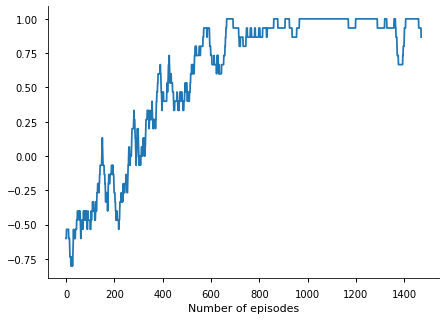

In [33]:
# DO NOT CHANGE THIS CELL

# Experiment configs.
train_episodes = 1500
discount_factor = .99

# Create environment.
env = catch.Catch(seed=42)

# Build and initialize network.
rng = jax.random.PRNGKey(44)
rng, init_rng = jax.random.split(rng)
sample_input = env.observation_spec().generate_value()
parameters = init_net(init_rng, sample_input)

# Initialize optimizer state.
opt_state = opt_init(parameters)

# Apply updates
def apply_updates(params, updates):
  return jax.tree_multimap(lambda p, u: p + u, params, updates)

# Jit.
opt_update = jax.jit(opt_update)
apply_updates = jax.jit(apply_updates)

print(f"Training agent for {train_episodes} episodes...")
all_episode_returns = []

for _ in range(train_episodes):
  episode_return = 0.
  timestep = env.reset()
  obs_tm1 = timestep.observation

  # Sample initial action.
  rng, policy_rng = jax.random.split(rng)
  a_tm1 = softmax_policy(parameters, policy_rng, obs_tm1)

  while not timestep.last():
    # Step environment.
    new_timestep = env.step(int(a_tm1))

    # Sample action from agent policy.
    rng, policy_rng = jax.random.split(rng)
    a_t = softmax_policy(parameters, policy_rng, new_timestep.observation)

    # Update params.
    r_t = new_timestep.reward
    discount_t = discount_factor * new_timestep.discount
    dJ_dtheta = compute_gradient(
        parameters, obs_tm1, a_tm1, r_t, discount_t,
        new_timestep.observation)
    updates, opt_state = opt_update(dJ_dtheta, opt_state)
    parameters = apply_updates(parameters, updates)

    # Within episode book-keeping.
    episode_return += new_timestep.reward
    timestep = new_timestep
    obs_tm1 = new_timestep.observation
    a_tm1 = a_t

  # Experiment results tracking.
  all_episode_returns.append(episode_return)

# Plot learning curve.
plot_learning_curve(all_episode_returns)

# B) An alternative update

You are going to implement a different kind of agent.

Like an actor-critic, it learns online from a single stream of experience, updating the parametes after each transition in the environment.

### Neural networks


The agent will reuse the same neural network we defined for the actor-critic:
* the scalar output will be trained via TD to estimate state values
* the vector preferences `p` will be updated according to a different rule.

### Choosing actions

As in actor-critics, the (stochastic) mapping from `observations` to `actions` depends on the vector of preferences `p` from the network.

### Q6 [2 marks]

The new agent's policy will have the signature `action = epsilon_greedy_policy(parameters, key, observation)`,
* Take as inputs the current network parameters `parameters`, a JAX random `key` and the current `observation`
* Return with probability `0.9` the greedy `action` with respect to the preferences `p`, ties must be broken at random.
* Return an action uniformly at random with probability `0.1`

In [34]:
@jax.jit
def epsilon_greedy_policy(parameters, key, observation):
    """Sample action from an epsilon-greedy policy."""
    eps = 0.1

    # Get the state value and next action
    v_next, act = apply_net(parameters, observation)

    # Use softmax to get preference
    preference = jax.nn.softmax(act)

    # Get the greedy action probabilites 
    greedy_actions = (preference == preference.max(axis=-1, keepdims=True))
   
    # Define the probability from Greedy actions
    prob = greedy_actions / greedy_actions.sum(axis=-1, keepdims=True)
    
    # Random probability
    prob_random = jnp.ones_like(prob) / preference.shape[-1]
    
    # Get the epsilon greedy probability
    probs = (1 - eps) * prob + eps * prob_random
    
    # Define the next action using the probabilities 
    next_act = jax.random.choice(key, jnp.arange(0, preference.shape[-1]), p=probs)
    return next_act

### Q7 [3 marks]

The parameters $w_p$ of the preferences $p_{w_p}(s, a)$ will be update according to the following gradient-based update:

$$\Delta w_p = \alpha (R_{t+1} + \gamma v(S_{t+1}) - p(S_{t}, A_t)) \nabla p(S_t, A_t))$$

where `v` is the state value trained by TD as in the actor critic.

You musy implement this in the function `preference_gradient`, with the same signature as `policy_gradient`

In [35]:
def preference_loss(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    # Get the baseline and current action
    v_baseline, curr_act = apply_net(parameters, obs_tm1)
    
    # Get the state value and next action
    v_next, next_act = apply_net(parameters, obs_t)
    
    # Get the loss - stopping the gradient
    grads = jax.lax.stop_gradient(r_t + discount_t * v_next - curr_act[a_tm1])
    grads = jax.tree_multimap(lambda g_i: g_i*curr_act[a_tm1], grads)
    return grads

def preference_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  # Return the grad
  grads = jax.grad(preference_loss)(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t) 
  return grads

### Updating shared parameters

Just like in the actor critic the overall update to the parameters is a combination of two quantities:
* the new update we defined for the vector of preferences
* the same TD update to the scalar output that we used in the actor critic

In [36]:
@jax.jit
def compute_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  pgrads = preference_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  vgrads = value_update(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  return jax.tree_multimap(lambda pg, td: pg + td, pgrads, vgrads)

### Optimisation

The gradient updates are rescaled using the same optimiser used for the actor-critic.

### Run experiments

Run the cell below to show the performance of the new agent.

Training agent for 15000 episodes...


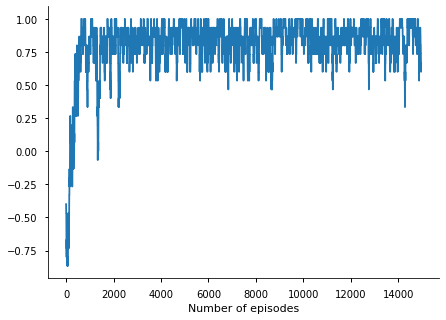

In [37]:
# DO NOT CHANGE THIS CELL

# Experiment configs.
train_episodes = 15000
discount_factor = .99

# Create environment.
env = catch.Catch(seed=42)

# Build and initialize network.
rng = jax.random.PRNGKey(44)
rng, init_rng = jax.random.split(rng)
sample_input = env.observation_spec().generate_value()
parameters = init_net(init_rng, sample_input)

# Initialize optimizer state.
opt_state = opt_init(parameters)

# Apply updates
def apply_updates(params, updates):
  return jax.tree_multimap(lambda p, u: p + u, params, updates)

# Jit.
opt_update = jax.jit(opt_update)
apply_updates = jax.jit(apply_updates)

print(f"Training agent for {train_episodes} episodes...")
all_episode_returns = []

for _ in range(train_episodes):
  episode_return = 0.
  timestep = env.reset()
  obs_tm1 = timestep.observation

  # Sample initial action.
  rng, policy_rng = jax.random.split(rng)
  a_tm1 = epsilon_greedy_policy(parameters, policy_rng, obs_tm1)

  while not timestep.last():
    # Step environment.
    new_timestep = env.step(int(a_tm1))

    # Sample action from agent policy.
    rng, policy_rng = jax.random.split(rng)
    a_t = epsilon_greedy_policy(parameters, policy_rng, new_timestep.observation)

    # Update params.
    r_t = new_timestep.reward
    discount_t = discount_factor * new_timestep.discount

    dJ_dtheta = compute_gradient(
        parameters, obs_tm1, a_tm1, r_t, discount_t,
        new_timestep.observation)
    updates, opt_state = opt_update(dJ_dtheta, opt_state)
    parameters = apply_updates(parameters, updates)

    # Within episode book-keeping.
    episode_return += new_timestep.reward
    timestep = new_timestep
    obs_tm1 = new_timestep.observation
    a_tm1 = a_t

  # Experiment results tracking.
  all_episode_returns.append(episode_return)

# Plot learning curve.
plot_learning_curve(all_episode_returns)

### Q8 [6 marks]

[2pts]: What is the best asymptotic average return that can be achieved by the actor-critic agent described in `Part 2A)`? Can this be futher improved, and if so: how? Explain your answer.

> The best asymptotic average return achieved is 1.0. This is because the actor-critic agents acts greedily at every step. As we can see from the graph, the acot-critic agent converges to 1 after around 800 steps.

[2pts] What is the best asymptotic average return that can be achieved by the second agent described in `Part 2B)`? Can this be futher improved, and if so: how? Explain your answer.

> The best asymptotic average return achieved is also 1.0. This is because the actor-critic agents acts greedily at almost every step. Although, we have a 10% chance of choosing a random action. With a large number of steps, this still converges. If we run the actor-critic agent for 1500 steps instead of 15,000 then we are not guaranteed to acheive an asymptotic average return of 1.0. Below is the graph of running the actor-critic agent for 1500 steps. 
This can be further improved by minimizing epsilon, and essentially acting Greedy at every step.

[2pts] What quantity do the preferences `p` estimate in the second agent described in Part B?

> The Q values - the cumulative reward given the current state and action pair.

Training agent for 1500 episodes...


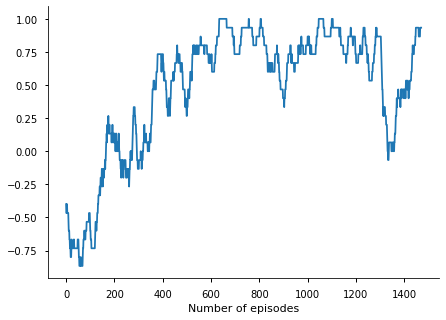

In [38]:
# DO NOT CHANGE THIS CELL

# Experiment configs.
train_episodes = 1500
discount_factor = .99

# Create environment.
env = catch.Catch(seed=42)

# Build and initialize network.
rng = jax.random.PRNGKey(44)
rng, init_rng = jax.random.split(rng)
sample_input = env.observation_spec().generate_value()
parameters = init_net(init_rng, sample_input)

# Initialize optimizer state.
opt_state = opt_init(parameters)

# Apply updates
def apply_updates(params, updates):
  return jax.tree_multimap(lambda p, u: p + u, params, updates)

# Jit.
opt_update = jax.jit(opt_update)
apply_updates = jax.jit(apply_updates)

print(f"Training agent for {train_episodes} episodes...")
all_episode_returns = []

for _ in range(train_episodes):
  episode_return = 0.
  timestep = env.reset()
  obs_tm1 = timestep.observation

  # Sample initial action.
  rng, policy_rng = jax.random.split(rng)
  a_tm1 = epsilon_greedy_policy(parameters, policy_rng, obs_tm1)

  while not timestep.last():
    # Step environment.
    new_timestep = env.step(int(a_tm1))

    # Sample action from agent policy.
    rng, policy_rng = jax.random.split(rng)
    a_t = epsilon_greedy_policy(parameters, policy_rng, new_timestep.observation)

    # Update params.
    r_t = new_timestep.reward
    discount_t = discount_factor * new_timestep.discount

    dJ_dtheta = compute_gradient(
        parameters, obs_tm1, a_tm1, r_t, discount_t,
        new_timestep.observation)
    updates, opt_state = opt_update(dJ_dtheta, opt_state)
    parameters = apply_updates(parameters, updates)

    # Within episode book-keeping.
    episode_return += new_timestep.reward
    timestep = new_timestep
    obs_tm1 = new_timestep.observation
    a_tm1 = a_t

  # Experiment results tracking.
  all_episode_returns.append(episode_return)

# Plot learning curve.
plot_learning_curve(all_episode_returns)